In [4]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

import pandas as pd
import numpy as np
import pickle
import time
import shap
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

from sm_utils import sampling, evaluate, save_model, load_model
from sm_utils import make_train_data,  make_test_data, df_to_md_table

In [2]:
DATA_PATH = '/home/dmig/work/upsell/data'
MODEL_PATH = '/home/dmig/work/upsell/model'

In [6]:
RESULT_PATH = '/home/dmig/work/upsell/result/shap_value'

In [7]:
## data
sample01 = pd.read_pickle(os.path.join(RESULT_PATH,'sample01.pkl'))
sample05 = pd.read_pickle(os.path.join(RESULT_PATH,'sample05.pkl'))
sample06 = pd.read_pickle(os.path.join(RESULT_PATH, 'sample06.pkl'))

In [17]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc', #logloss, error, auc
    'n_estimators': 500,
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'scale_pos_weight': 4, # neg/pos
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 23,
    'nthread': 40,
    'verbosity': 1
}

In [22]:
clf2 = xgb.XGBClassifier(**xgb_params)

In [10]:
df_mart01 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201901.pkl'))

In [11]:
df_mart05 = pd.read_pickle(os.path.join(DATA_PATH, 'df_mart_201905.pkl'))

In [12]:
total_feature = list(df_mart01.columns)
feature_cols = [c for c in total_feature if c not in ['svc_mgmt_num', 'label']]

In [13]:
result = make_train_data(df_mart01)

trn_idx = result['trn']['idx']
x_trn = result['trn']['x']
y_trn = result['trn']['y']

val_idx = result['val']['idx']
x_val = result['val']['x']
y_val = result['val']['y']
print('x_trn: ', x_trn.shape)
print('x_val: ', x_val.shape)

make_train_data +++
label/sample:  0.2
sample/total:  0.09245956872759263
make_data_for_modeling---
x_trn:  (1344452, 79)
x_val:  (336113, 79)


In [21]:
result = make_test_data(df_mart05)
idx = result['idx']
x_test = result['x']
y_test = result['y']

In [23]:
t1 = time.time()
clf2.fit(x_trn.values, y_trn.label.values, 
         eval_set=[(x_trn.values, y_trn.label.values), 
                   (x_val.values, y_val.label.values)],
        early_stopping_rounds=100, verbose=50)
print('elapsed time: ', time.time()-t1)

[0]	validation_0-auc:0.75637	validation_1-auc:0.755426
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.887091	validation_1-auc:0.884807
[100]	validation_0-auc:0.915584	validation_1-auc:0.912362
[150]	validation_0-auc:0.927505	validation_1-auc:0.923735
[200]	validation_0-auc:0.934938	validation_1-auc:0.930581
[250]	validation_0-auc:0.940875	validation_1-auc:0.936061
[300]	validation_0-auc:0.944856	validation_1-auc:0.939568
[350]	validation_0-auc:0.949288	validation_1-auc:0.943651
[400]	validation_0-auc:0.95156	validation_1-auc:0.945473
[450]	validation_0-auc:0.954092	validation_1-auc:0.947638
[499]	validation_0-auc:0.956067	validation_1-auc:0.949285
elapsed time:  262.32805371284485


In [33]:
new_cols = ['f{}'.format(n) for n in range(79)]

In [34]:
xt = x_test.copy()
xt.columns = new_cols

In [35]:
xt.head()

f0  f1  f2   f3  f4    f5    f6     f7        f8       f9  ...  f69  f70  \
0   1  67   2  500   9  8191   634  51700    3.0000   858000  ...    2    0   
1   0  39   1  697   6  6039  1817  12100    0.0001   253000  ...    0    0   
2   0  68   1  891   2  5501  2934  12100    0.0001   671000  ...    0    0   
3   1  60   2  720   6  4643   139  43000    2.0000   357500  ...    1    0   
4   0  31   3  883   2  5018   517  79000  150.0000  1362900  ...    0    0   

   f71  f72  f73  f74  f75  f76  f77  f78  
0    0    0    0    0    1    0    0    2  
1    0    0    0    0    0    0    0    3  
2    0    0    0    0    0    0    0    2  
3    0    0    0    0    1    0    0    3  
4    0    0    0    0    0    0    0    1  

[5 rows x 79 columns]

In [36]:
y_pred = clf2.predict_proba(xt)[:,1]

In [37]:
y_pred

array([0.67659837, 0.24780495, 0.20739824, ..., 0.05589266, 0.21515793,
       0.10860471], dtype=float32)

In [39]:
y_pred_class = [1 if c >= 0.5 else 0 for c in y_pred]

In [40]:
y_true = y_test.label.values

In [43]:
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np
import multiprocessing
import pickle
import random
import time
import shap
import os
import gc

from tigger.util.hive_tools import hive_connection, load_from_hive, load_to_hive

from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from collections import defaultdict
from inspect import signature
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# result ----------
df_result = pd.DataFrame({'y_true': y_true, 
                          'y_pred': y_pred,
                          'y_pred_class': y_pred_class})

# eval metrics ----------
df_metrics = pd.DataFrame({'acc': accuracy_score(y_true, y_pred_class),
                           'recall': recall_score(y_true, y_pred_class),
                           'precision': precision_score(y_true, y_pred_class),
                           'f1_score': f1_score(y_true, y_pred_class),
                           'auc': roc_auc_score(y_true, y_pred)}, index=[0])
print(df_metrics)

# confusion matrix ----------
df_confusion_matrix = pd.DataFrame(confusion_matrix(y_true, 
                                                    y_pred_class,
                                                    labels=[1,0]),
                                   index=['true: 1', 'true: 0'], 
                                   columns=['pred: 1', 'pred: 0'])
print(df_confusion_matrix)

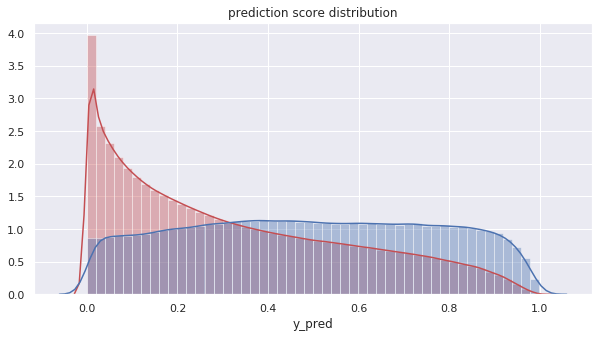

In [49]:
# df_dict ----------
df_dict = {
    'result': df_result,
    'metrics': df_metrics,
    'confusion_matrix': df_confusion_matrix,
#     'feature_importance': df_fea
}

# prediction score distribution ----------
sns.set(rc={'figure.figsize': (10,5)})
plt.title('prediction score distribution')

sns.distplot(df_result[df_result.y_true==0].y_pred, norm_hist=True, color='r', label='true: 0')
sns.distplot(df_result[df_result.y_true==1].y_pred, norm_hist=True, label='true: 1')
plt.show()

# precision recall curve ----------
sns.set(rc={'figure.figsize': (10,5)})

precision, recall, _ = precision_recall_curve(df_result.y_true, df_result.y_pred)
average_precision = average_precision_score(df_result.y_true, df_result.y_pred)

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

p_ratio = df_result.y_true.sum()/df_result.shape[0]
plt.hlines(p_ratio, 0, 1)

plt.xlabel('recall')
plt.ylabel('precision')
plt.xlim([0.0, 1.0])    
plt.title('precision-recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [24]:
eval_result = evaluate(x_test, y_test.label.values, clf2, clf_name='xgb')

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78'] ['sex_cd', 'age', 'svc_gr', 'mng_nice_cb_scr', 'mng_nice_cb_grd', 'svc_scrb_period', 'last_equip_period', 'bas_fee_amt', 'bas_ofr_data_gb', 'eqp_out_prc', 'allot_prn_amt', 'pmth_inv_bamt', 'family_yn', 'family_small_yn', 'twld_visit_cnt_bf_m0', 'twld_visit_cnt_bf_m1', 'twld_visit_cnt_bf_m2', 'avg_twld_visit_cnt', 'twld_fee_visit_cnt_bf_m0', 'twld_fee_visit_cnt_bf_m1', 'twld_fee_visit_cnt_bf_m2', 'avg_twld_fee_visit_cnt', 'ansim_yn', 'ref_data_usage_in_gb_bf_m0', 'ref_data_usage_in_gb_bf_m1', 'ref_data_usage_in_gb_bf_m2', 'data_usage_in_gb_bf_m0', 'data_usage_in_gb_bf_m1', 'data_usage_in_gb_bf_m2', 'avg_data_usage_in_gb', 'overage_bf0', 'overage_bf1', 'overage_bf2', 'copn_data_u1_yn_bf_m0', 'copn_data_u1_yn_bf_m1', 'copn_data_u1_yn_bf_m2', 'data_gift_send_yn_bf_m0', 'data_gift_send_yn_bf_m1', 'data_gift_send_yn_bf_m2', 'data_gift_recv_yn_bf_m0', 'data_gift_recv_yn_bf_m1', 'data_gift_recv_yn_bf_m2', 'sec_dev_yn', 'avg_mbr_use_cnt', 'avg_subscription_period', 'avg_chg_duration', 'real_arpu_bf_m1', 'real_arpu_bf_m2', 'real_arpu_bf_m3', 'real_avg_arpu', 'bf_m3_fee_chg_cnt', 'bf_m6_sum_data_usage_in_gb', 'bf_m6_avg_data_usage_in_gb', 'data_usage_ratio', 'bf_m6_data_usage_ratio_avg', 'bf_m6_data_over_usage_cnt', 'bf_m3_data_over_usage_cnt', 'copn_left_cnt_bf0', 'copn_left_cnt_bf1', 'copn_left_cnt_bf2', 'overage_5k_3m', 'overage_5k_3m_or', 'overage_inc_3m', 'refill_0_yn', 'ref_data_use_3m', 'gift_recv_3m', 'data_incr_3m', 'tw_spd_chk_1m', 'tw_tplan_chk_1m', 'mth_cnsl_cnt_bf_m0', 'mth_cnsl_cnt_bf_m1', 'mth_cnsl_cnt_bf_m2', 'dsat_cnsl_cnt_bf_m0', 'dsat_cnsl_cnt_bf_m1', 'dsat_cnsl_cnt_bf_m2', 'simpl_ref_cnsl_cnt_bf_m0', 'simpl_ref_cnsl_cnt_bf_m1', 'simpl_ref_cnsl_cnt_bf_m2', 'channel']
expected f14, f12, f9, f44, f22, f65, f30, f55, f37, f3, f46, f40, f6, f58, f54, f49, f47, f59, f29, f77, f63, f38, f61, f11, f28, f18, f10, f23, f17, f33, f19, f20, f52, f53, f70, f73, f60, f0, f31, f64, f32, f48, f15, f50, f78, f8, f74, f39, f1, f45, f69, f27, f4, f66, f2, f41, f7, f51, f21, f5, f42, f26, f76, f25, f34, f56, f24, f57, f13, f62, f35, f68, f71, f43, f75, f16, f36, f72, f67 in input data
training data did not have the following fields: overage_bf1, twld_visit_cnt_bf_m0, avg_mbr_use_cnt, twld_visit_cnt_bf_m2, copn_data_u1_yn_bf_m1, bf_m6_sum_data_usage_in_gb, bf_m3_data_over_usage_cnt, eqp_out_prc, overage_inc_3m, twld_visit_cnt_bf_m1, avg_twld_fee_visit_cnt, twld_fee_visit_cnt_bf_m1, allot_prn_amt, gift_recv_3m, mth_cnsl_cnt_bf_m0, data_usage_in_gb_bf_m0, avg_chg_duration, data_incr_3m, twld_fee_visit_cnt_bf_m0, bas_fee_amt, tw_spd_chk_1m, svc_gr, tw_tplan_chk_1m, copn_data_u1_yn_bf_m2, data_gift_send_yn_bf_m2, data_gift_recv_yn_bf_m1, dsat_cnsl_cnt_bf_m1, data_gift_recv_yn_bf_m0, real_avg_arpu, ref_data_use_3m, copn_data_u1_yn_bf_m0, refill_0_yn, mth_cnsl_cnt_bf_m1, ref_data_usage_in_gb_bf_m2, copn_left_cnt_bf2, overage_bf0, data_gift_send_yn_bf_m1, mng_nice_cb_grd, copn_left_cnt_bf0, data_usage_in_gb_bf_m2, avg_data_usage_in_gb, bf_m6_data_usage_ratio_avg, twld_fee_visit_cnt_bf_m2, overage_5k_3m, age, simpl_ref_cnsl_cnt_bf_m0, family_small_yn, overage_bf2, bf_m3_fee_chg_cnt, ref_data_usage_in_gb_bf_m1, mth_cnsl_cnt_bf_m2, data_gift_recv_yn_bf_m2, simpl_ref_cnsl_cnt_bf_m1, pmth_inv_bamt, real_arpu_bf_m1, bf_m6_data_over_usage_cnt, overage_5k_3m_or, channel, bas_ofr_data_gb, avg_subscription_period, ansim_yn, copn_left_cnt_bf1, data_usage_ratio, data_usage_in_gb_bf_m1, sex_cd, mng_nice_cb_scr, family_yn, avg_twld_visit_cnt, dsat_cnsl_cnt_bf_m0, dsat_cnsl_cnt_bf_m2, bf_m6_avg_data_usage_in_gb, svc_scrb_period, ref_data_usage_in_gb_bf_m0, simpl_ref_cnsl_cnt_bf_m2, sec_dev_yn, last_equip_period, real_arpu_bf_m3, data_gift_send_yn_bf_m0, real_arpu_bf_m2

In [ ]:
# parameter
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': True,
    'num_leaves': 64,
    'lambda_l1': 3,
    'lambda_l2': 1,
    'learning_rate': 0.05,
    'num_threads': 30,
}

In [ ]:
lgb_trn = lgb.Dataset(x_trn, y_trn, feature_name=feature_cols)
lgb_val = lgb.Dataset(x_val, y_val, feature_name=feature_cols)

In [ ]:
# modeling
t1 = time.time()
clf = lgb.train(lgb_params,
                train_set=lgb_trn,
                valid_sets=[lgb_trn, lgb_val],
                num_boost_round=2000,
                early_stopping_rounds=100,
                verbose_eval=50)
print('elapsed time:', time.time()-t1)

In [ ]:
eval_result = evaluate(x_test, y_test.label.values, clf, clf_name='lgb')